In [69]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

In [70]:
import pandas as pd
import torch
from torch.optim import Adam
from torch import nn
from torch.utils.data import DataLoader, Dataset

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [71]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 3e-4
BATCH_SIZE = 64
EPOCHS = 15
PROB = 0.5

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [72]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Data Preparation**

**Load Data**

In [73]:
df = pd.read_csv('twitter-suicidal-data.csv')
df_copy = pd.read_csv('twitter-suicidal-data.csv')
df

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1
...,...,...
9114,have you ever laid on your bed at night and cr...,1
9115,the fault the blame the pain s still there i m...,1
9116,stop asking me to trust you when i m still cou...,1
9117,i never know how to handle sadness crying make...,1


**Data Preprocessing**


In [74]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [75]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

In [76]:
def convert_emoji_to_text(text):
  text = emoji.demojize(text)
  text = re.sub(r':\S+:', ' ', text)
  return text

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
  text = text.lower()
  # text = re.sub(r'[^\w\s]', '', text)
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = re.sub(r'\d', '', text)
  text = re.sub(r'\b(?:www|https?|http)\S*', '', text)
  text = re.sub(r'@\s*<[^>]*>', '', text)
  text = text.strip()
  text = convert_emoji_to_text(text)
  # text = re.sub(r'[^\w\s]', '', text) #remove non-word characters

  tokens_temp = word_tokenize(text)
  lemmatized_tokens = [WordNetLemmatizer().lemmatize(token) for token in tokens_temp]
  tokens = [token for token in lemmatized_tokens if token not in stopwords]

  return tokens

In [77]:
## TODO: Show some samples before/after preprocessing
random_tweets = df.iloc[:, 0].sample(n=5).values
for tweet in random_tweets:
  print('Before:')
  print(tweet)
  new_tweet = preprocess_data(tweet)
  print('After:')
  print(new_tweet)

Before:
 i want to go outtt 
After:
['want', 'go', 'outtt']
Before:
i will probably kill myself in a week throwaway for obvious reasons i dont want my few friends to know because theyll try to stop me probably also be posting this on subreddits that have helped me to say thanksabout 6 months ago i was dumped by the first girl i ever truly loved before that i was getting helped for my depression and starting to feel better with her by my side everything is different now since ive gotten back to college and back to near her ive stopped going to counseling stopped talking to everyone about howi am doing and acting likei am really happy to when i think about slicing my neck open at least every minutei cant focus on school or friendsi am too afraid to leave my room my school is very small and i dont want to see her so instead i just rot away in my personal hell the few friends i have rarely ask me to hang out or talk to me so i dont have much of a social lifeeveryday all i do is think about

In [78]:
#pre-process data + add new column(prep_tweet)
num_of_tokens = []
labels = []
prep_tweets = []
for index, row in df.iterrows():
    tweet = row['tweet']
    label = row['intention']
    prep_tweet = preprocess_data(tweet)
    prep_tweets.append(prep_tweet)
    num_of_tokens.append(len(prep_tweet))
    labels.append(label)
df['tokens'] = prep_tweets
df_tokenized_label = pd.DataFrame({'num_of_tokens': num_of_tokens, 'label': labels})

In [79]:
df_tokenized_label

,num_of_tokens,label
0,42,1
1,22,1
2,32,1
3,30,1
4,10,1
...,...,...
9114,14,1
9115,10,1
9116,10,1
9117,8,1


In [80]:
df

,tweet,intention,tokens
0,my life is meaningless i just want to end my l...,1,"[life, meaningless, want, end, life, badly, li..."
1,muttering i wanna die to myself daily for a fe...,1,"[muttering, wan, na, die, daily, month, feel, ..."
2,work slave i really feel like my only purpose ...,1,"[work, slave, really, feel, like, purpose, lif..."
3,i did something on the 2 of october i overdose...,1,"[something, october, overdosed, felt, alone, h..."
4,i feel like no one cares i just want to die ma...,1,"[feel, like, one, care, want, die, maybe, feel..."
...,...,...,...
9114,have you ever laid on your bed at night and cr...,1,"[ever, laid, bed, night, cried, good, enough, ..."
9115,the fault the blame the pain s still there i m...,1,"[fault, blame, pain, still, alone, inside, bro..."
9116,stop asking me to trust you when i m still cou...,1,"[stop, asking, trust, still, coughing, water, ..."
9117,i never know how to handle sadness crying make...,1,"[never, know, handle, sadness, cry, make, feel..."


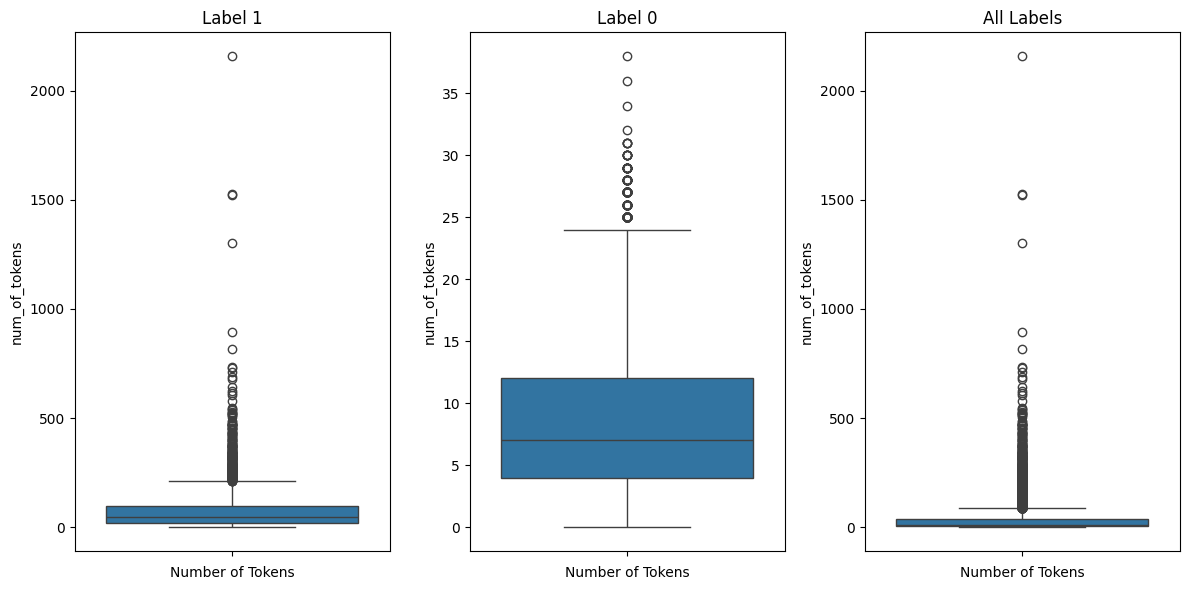

In [81]:
#show_box_plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y='num_of_tokens', data=df_tokenized_label[df_tokenized_label['label'] == 1])
plt.title('Label 1')
plt.xlabel('Number of Tokens')

plt.subplot(1, 3, 2)
sns.boxplot(y='num_of_tokens', data=df_tokenized_label[df_tokenized_label['label'] == 0])
plt.title('Label 0')
plt.xlabel('Number of Tokens')

plt.subplot(1, 3, 3)
sns.boxplot(y='num_of_tokens', data=df_tokenized_label)
plt.title('All Labels')
plt.xlabel('Number of Tokens')

plt.tight_layout()
plt.show()

In [82]:
label_1_stats = df_tokenized_label[df_tokenized_label['label'] == 1]['num_of_tokens'].describe()
label_0_stats = df_tokenized_label[df_tokenized_label['label'] == 0]['num_of_tokens'].describe()
all_labels_stats = df_tokenized_label['num_of_tokens'].describe()
print('LABEL 1:')
print(label_1_stats)

print('LABEL 0:')
print(label_0_stats)

print('ALL LABELS:')
print(all_labels_stats)

LABEL 1:
count    3998.000000
mean       75.051526
std        99.336920
min         0.000000
25%        20.000000
50%        46.000000
75%        97.000000
max      2159.000000
Name: num_of_tokens, dtype: float64
LABEL 0:
count    5121.000000
mean        9.097051
std         6.548419
min         0.000000
25%         4.000000
50%         7.000000
75%        12.000000
max        38.000000
Name: num_of_tokens, dtype: float64
ALL LABELS:
count    9119.000000
mean       38.013159
std        73.626745
min         0.000000
25%         6.000000
50%        12.000000
75%        38.000000
max      2159.000000
Name: num_of_tokens, dtype: float64


**Questions of pre-proccessing**

1)There is a common approach to lowercasing everything for the sake of simplicity. It helps to maintain the consistency flow during the NLP tasks and text mining. in an other words, we don’t want machine learning algorithms to read Laptop, LAPTOP, and laptop as three separate words.
here are some advantages and disadvantages:

Advantages

  * Case Insensitivity: Lowercase conversion makes the analysis case-insensitive. Words like "Apple" and "apple" are treated as the same token, reducing redundancy and simplifying text analysis.

  * Consistency: It ensures uniformity in the dataset. Without this, "Word", "word", and "WORD" would be considered different tokens, which could lead to fragmented and less accurate results.

  * Reduced Dimensionality: By treating all case variations of a word as the same token, the dimensionality of the feature space is reduced. This simplification can lead to faster and more efficient computations.

  * Improved Model Performance: Many NLP models, especially those based on statistical methods or traditional machine learning algorithms, perform better when they don't have to account for case variations.

  * Simpler Vocabulary: It helps in creating a smaller and more manageable vocabulary, which is beneficial for tasks like building a dictionary, indexing, or searching.

Disadvantages

  * Loss of Information: Some important information might be lost. For example, proper nouns (e.g., "Apple" the company vs. "apple" the fruit) can provide context that is essential for accurate interpretation.

  * Ambiguity in Context: Case can be indicative of sentence boundaries or emphasis. Lowercasing might lead to ambiguities where the case of a word is crucial to understanding the sentence's meaning or structure.

  * Issues with Acronyms and Abbreviations: Acronyms and abbreviations that are typically written in uppercase might lose their significance or be confused with regular words. For example, "NASA" vs. "nasa".

  * Named Entity Recognition (NER): Lowercasing can complicate tasks like named entity recognition, where distinguishing between "Bush" (a surname) and "bush" (a plant) is important.

  * Domain-Specific Requirements: In some domains, the case is significant and losing this information can reduce the accuracy of the model. For instance, in legal or medical texts, capitalization can denote specific terminologies or categories.

  ============================================================

  2)Overall, when numbers are irrelevant for analysis we can remove them and it helps to reduce dimention and lead to increase speed.But when numbers are important information in our dataset, removing thenm lead to remove imortant information and lose performance.

  Here are some advantages and disadvantages of this aproach in general:
  Advantages:

  * Focus on Textual Content: Removing numbers can help focus the analysis on the textual content of the data, especially when the numbers are not relevant to the analysis or the context.

  * Reduced Dimensionality: Removing numbers can reduce the dimensionality of the data, which can lead to faster processing and training of machine learning models.

  * Improved Generalization: By removing numbers, the model may generalize better to unseen data, as it does not rely on specific numerical values that may be present in the training data but absent in the test data.

  * Simplification of Text: Removing numbers can simplify the text and make it easier to process, especially for tasks like sentiment analysis or text classification where numerical values may not provide meaningful information.

Disadvantages:

  * Loss of Information: Removing numbers may lead to loss of valuable information, especially in cases where numbers are important for the analysis or interpretation of the text.

  * Misinterpretation of Text: In some cases, numbers may carry important meaning or context in the text. Removing them can lead to misinterpretation or loss of context.

  * Loss of Structure: Numbers may be part of structured data, such as dates, times, or measurements. Removing them can disrupt the structure of the text and make it harder to extract meaningful information.

  * Impact on Specific Tasks: For certain tasks, such as text summarization or information extraction, numbers may be relevant and removing them could hinder the performance of the model.

  ====================================================================

  3)
  

**Word2Vec - Word Embedding**

In [83]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [84]:
# Mount Google Drive and load word_2_vec
from google.colab import drive
drive.mount('/content/drive')
W2V_PATH = '/content/drive/My Drive/models/word2vec_model.bin'
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading Word2Vec model...
Word2Vec model is loaded.


In [85]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

**Question of creating features vector**

1)Here are some methods that we can use for handling tokenized words that do not exist in the Word2Vec dataset:
  * **Ignore them:** You can simply ignore the tokenized words that do not exist in the Word2Vec dataset and proceed with your analysis. This approach may be suitable if the number of out-of-vocabulary words is relatively small and does not significantly affect your overall analysis.

  * **Replace with a special token:** You can replace out-of-vocabulary words with a special token, such as <UNK> (unknown), to indicate that they are not present in the Word2Vec dataset. This approach allows you to still include these words in your analysis while distinguishing them from the words present in the Word2Vec dataset.

  * **Use custom word embeddings:** If the out-of-vocabulary words are important for your analysis, you can consider training custom word embeddings on your specific dataset. This allows you to capture the semantic meanings of words that may not be present in pre-trained word embeddings like Word2Vec.

  * **Use a different word embedding model:** You can explore other pre-trained word embedding models besides Word2Vec, such as GloVe, FastText, or BERT embeddings. Different models may have different coverage of vocabulary, so switching to a different model may help address the issue of out-of-vocabulary words.

  * **Handle them separately:** You can handle out-of-vocabulary words separately in your analysis, such as by assigning them a default vector representation or using a different approach altogether for processing them.

All these methods have their advantages and disadvantages that I mentioned them but the key point that help us to use which one of these methods, is the impotance of these tokenized and number of them in our data.

**Dataset**

In [86]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)
        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    #Done
    def _get_word_vectors(self, tokens: list) -> torch.tensor:
      # selected_tokenized = self._pad(tokens)
      tensor = np.zeros((SEQUENCE_LEN, EMBEDDING_VECTOR_DIM))
      for i in range(len(tokens)):
        if(tokens[i] in self.w2v_model):
          tensor[i] = self.w2v_model[tokens[i]]
        else:
          tensor[i] = np.zeros(300)

      tensor = torch.tensor(tensor, dtype=torch.float32)
      return tensor

    #Done
    def _pad(self, tokens: list):
      zero_vector = np.zeros((1, 300))
      if(len(tokens) >= SEQUENCE_LEN):
        tokens = tokens[:SEQUENCE_LEN]
      else:
        for i in range(SEQUENCE_LEN - len(tokens)):
          tokens.append('alangis')
      return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

**Prepare Data**

**Split Data into Train-valid**

In [87]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_copy, test_size=0.2, random_state=0)

**Create Datasets**

In [88]:
train_dataset = Twitter(train, w2v_model, SEQUENCE_LEN)
valid_dataset = Twitter(test, w2v_model, SEQUENCE_LEN)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

Deleted 0-Len Samples: 23


<ipython-input-86-346d366ef098>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-86-346d366ef098>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


Deleted 0-Len Samples: 8


<ipython-input-86-346d366ef098>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


Train dataset length: 7272
Valid dataset length: 1816


<ipython-input-86-346d366ef098>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


**Model and Train**

In [89]:
from tqdm import tqdm
import torch

@torch.no_grad()
def model_eval(model, loader, loss_function, device: str = 'auto'):
  """Returns test_loss, test_acc"""
  test_loss = 0.0
  test_acc = 0.0

  if device == "auto":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = model.to(device)
  itr = tqdm(loader, total=len(loader), leave=False)

  for inputs, labels in itr:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    # input_data = inputs.permute(0, 2, 1)
    outputs = model(inputs)

    # Calculate loss
    loss = loss_function(outputs, labels)
    test_loss += loss.item() * inputs.size(0)

    # Calculate accuracy
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels.data)
    test_acc += corrects.double()


    itr.set_description("(Eval)")
    itr.set_postfix(
      loss=round(loss.item(), 5),
      accuracy=test_acc,
    )


  test_loss = test_loss / len(loader.dataset)
  test_acc = test_acc / len(loader.dataset)

  return test_loss, test_acc

In [90]:
from tqdm import tqdm
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: str = 'auto',
):#str['cuda', 'cpu', 'auto']
    # if device == "auto":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # Create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
    print('train_loader', type(train_loader))

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        itr = tqdm(train_loader, total=len(train_loader), leave=False)

        for idx, (inputs, labels) in enumerate(itr, start=1):
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass to generate outputs
            # input_data = inputs.permute(0, 2, 1)
            outputs = model(inputs)

            # Calculate predictions and accuracy
            _, preds = torch.max(outputs, 1)
            corrects = torch.sum(preds == labels).item()
            epoch_acc += corrects / len(labels)

            # Calculate loss
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()

            # Zero previous gradients, backward pass, and update optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
                loss=round(loss.item(), 5),
                accuracy=round(epoch_acc / (idx), 5)
            )

        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(epoch_acc / len(train_loader))

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
        )

        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "valid_loss": valid_losses,
        "valid_acc": valid_accs,
    }
    return history

In [91]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5 * len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            # Ensure the tensor is on the CPU and converted to a NumPy array
            if isinstance(trend, torch.Tensor):
                if trend.is_cuda:
                    trend = trend.cpu().numpy()
                else:
                    trend = trend.numpy()
            else:
                trend = [t.cpu().numpy() if isinstance(t, torch.Tensor) and t.is_cuda else t.numpy() if isinstance(t, torch.Tensor) else t for t in trend]
            plt.plot(range(1, len(trend) + 1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()
    plt.show()

In [92]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")


    # TODO: code here, you must fill variables below
    # TODO: labels = true labels from the dataset
    # TODO: predicted = labels predicted by the model
    Labels = []
    Predictions = []
    for data in itr:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)

      Labels.extend(labels.cpu().numpy())
      Predictions.extend(predicted.cpu().numpy())

    labels = np.array(Labels)
    predicted = np.array(Predictions)

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


**Model's Network**

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [94]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Define the first set of convolutional layers
        self.conv1d_3_1 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=3, padding=1)
        self.conv1d_5_1 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=5, padding=2)
        self.conv1d_7_1 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=7, padding=3)

        # Define the second set of convolutional layers
        self.conv1d_3_2 = nn.Conv1d(in_channels=192, out_channels=128, kernel_size=3, padding=1)
        self.conv1d_5_2 = nn.Conv1d(in_channels=192, out_channels=128, kernel_size=5, padding=2)
        self.conv1d_7_2 = nn.Conv1d(in_channels=192, out_channels=128, kernel_size=7, padding=3)

        # Define pooling layers
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.avgpool = nn.AvgPool1d(kernel_size=2)

        # Define fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 3 * 32, 128)  # Adjust input size based on the pooled output size
        self.fc2 = nn.Linear(128, 2)  # Assuming binary classification

        # self.bn1 = nn.BatchNorm1d(128)
        # self.dropout = nn.Dropout(PROB)




    def forward(self, x):
        # Input shape: (batch_size, sequence_length, embedding_dim)
        # We need to transpose the input to shape: (batch_size, embedding_dim, sequence_length)
        x = x.transpose(1, 2)

        # Layer 1
        x1 = F.relu(self.conv1d_3_1(x))
        x2 = F.relu(self.conv1d_5_1(x))
        x3 = F.relu(self.conv1d_7_1(x))

        # Concatenate the outputs of Layer 1
        x = torch.cat((x1, x2, x3), dim=1)

        # Layer 2
        x1 = F.relu(self.conv1d_3_2(x))
        x2 = F.relu(self.conv1d_5_2(x))
        x3 = F.relu(self.conv1d_7_2(x))

        # Concatenate the outputs of Layer 2
        x = torch.cat((x1, x2, x3), dim=1)

        # Pooling
        x = self.maxpool(x)

        # Flatten
        x = self.flatten(x)
        x = self.fc1(x)
        # x = self.bn1(x)  # Batch Normalization
        x = F.relu(x)
        # x = self.dropout(x)  # Dropout
        x = self.fc2(x)

        return x


In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Training**


In [96]:
# TODO: instantiate your model here
model = CNN()

In [97]:
from torch.optim import Adam
cnn_model_train_history = train_model(model, BATCH_SIZE, torch.nn.CrossEntropyLoss(), Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY), EPOCHS, train_dataset, valid_dataset, 'auto')

train_loader <class 'torch.utils.data.dataloader.DataLoader'>


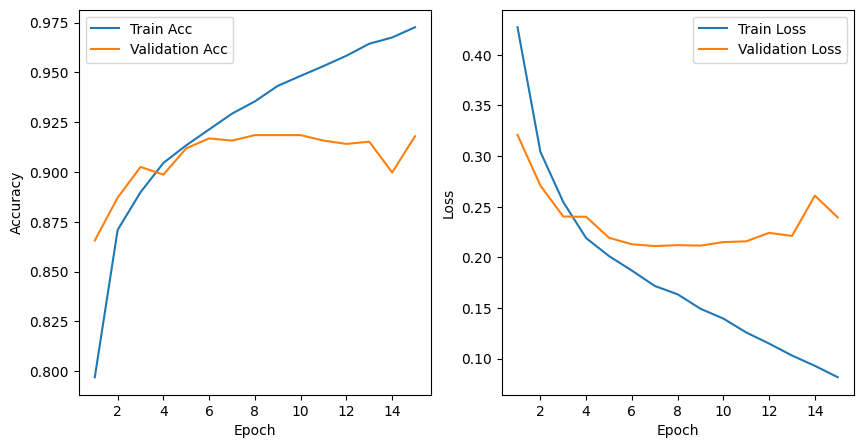

In [98]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

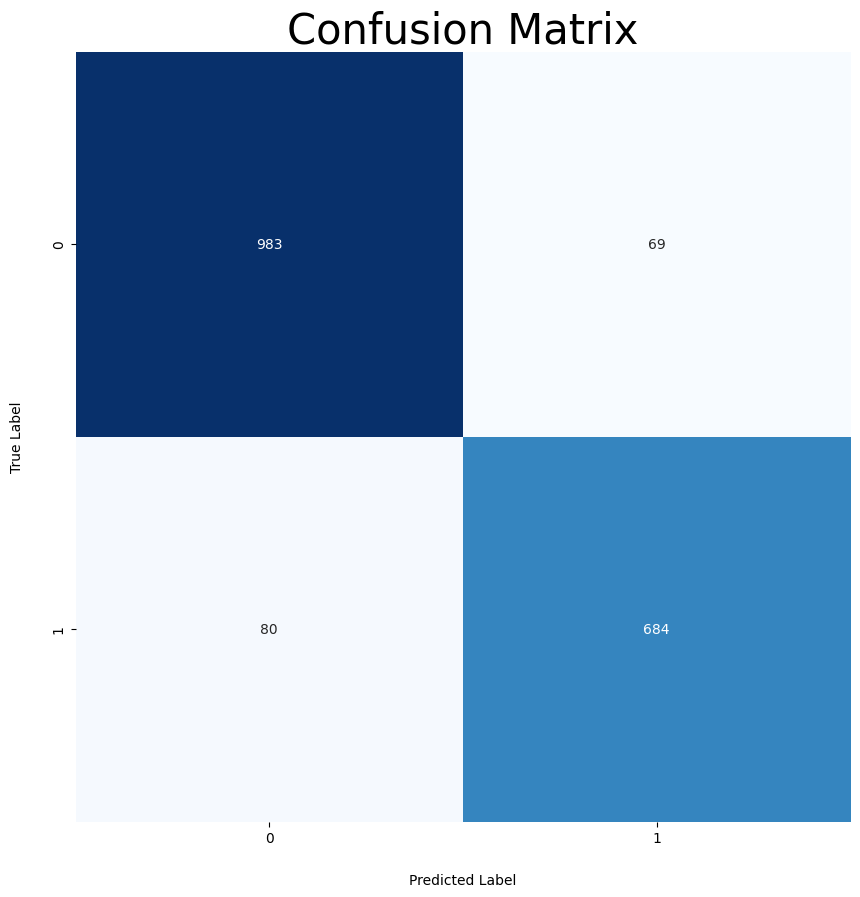

In [99]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [100]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.915
F1:        0.916
Precision: 0.917
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1052
           1       0.91      0.90      0.90       764

    accuracy                           0.92      1816
   macro avg       0.92      0.91      0.92      1816
weighted avg       0.92      0.92      0.92      1816



In [101]:
hyperparameters = {'LEARNING_RATE' : LEARNING_RATE ,'WEIGHT_DECAY' : WEIGHT_DECAY, 'BATCH_SIZE' : BATCH_SIZE, 'EPOCHS' : EPOCHS, 'SEQUENCE_LEN' : SEQUENCE_LEN, 'CNN_FILTERS' : CNN_FILTERS, 'PROB' : PROB}
results = {'Train Acc' : cnn_model_train_history["train_acc"], 'Validation Acc' : cnn_model_train_history["valid_acc"], 'Train Loss' : cnn_model_train_history["train_loss"], 'Validation Loss' : cnn_model_train_history["valid_loss"], 'Recall' : cnn_model_report['recall'], 'F1' : cnn_model_report['f1'], 'Precision' : cnn_model_report['precision']}

In [102]:
with open('/content/drive/My Drive/results.txt', 'a') as file:
    file.write('With Regularization\n')
    file.write('Hyperparameters:\n\n')
    for key, value in hyperparameters.items():
        file.write(f"{key}: {value}\n")
    file.write('\n')
    file.write('Results:\n\n')
    for key, value in results.items():
        file.write(f"{key}: {value}\n")
    file.write('\n\n')

**Questions of second part**


**Adam and its differences with gradient dicsent**

Adam optimizer is a popular optimization algorithm used in training neural networks. It stands for "Adaptive Moment Estimation." Adam combines the concepts of momentum and adaptive learning rates to achieve faster convergence during training.

Here's a brief overview of Adam and how it differs from traditional gradient descent:

1. **Adaptive Learning Rates**: In traditional gradient descent, the learning rate remains constant throughout training. However, Adam dynamically adjusts the learning rate for each parameter based on the past gradients, allowing it to converge faster and potentially avoid getting stuck in local minima.

2. **Momentum**: Adam incorporates momentum, which helps accelerate the optimization process by accumulating gradients from past time steps. This helps smooth out the optimization process, especially in the presence of noisy gradients or sparse data.

3. **Bias Correction**: Adam performs bias correction to adjust for the bias introduced due to the initialization of the moving averages. This correction ensures that the estimates of the first and second moments of the gradients are unbiased, particularly in the early stages of training.

4. **Initialization**: Adam requires initializing two moving average parameters, \( m \) and \( v \), which represent the first and second moments of the gradients, respectively. These parameters are initialized as zero vectors, and they are updated during training.

5. **Computational Efficiency**: While Adam is computationally efficient and converges quickly in many cases, it may require more memory due to the additional parameters (moving averages) it maintains compared to traditional gradient descent variants.

In summary, Adam optimizer differs from traditional gradient descent primarily due to its adaptive learning rate mechanism, incorporation of momentum, bias correction, and initialization of additional parameters for maintaining moving averages of gradients. These features collectively make Adam a powerful optimization algorithm for training deep neural networks.



**Cross Entropy Loss Function**

Cross-entropy, also known as logarithmic loss or log loss, is a popular loss function used in machine learning to measure the performance of a classification model.

It measures the average number of bits required to identify an event from one probability distribution, p, using the optimal code for another probability distribution, q. In other words, cross-entropy measures the difference between the discovered probability distribution of a classification model and the predicted values.

The cross-entropy loss function is used to find the optimal solution by adjusting the weights of a machine learning model during training. The objective is to minimize the error between the actual and predicted outcomes. Thus, a measure closer to 0 is a sign of a good model, whereas a measure closer to 1 is a sign of a poor-performing model.

In machine learning, loss functions help models determine how wrong it is and improve itself based on that wrongness. They are mathematical functions that quantify the difference between predicted and actual values in a machine learning model, but this isn’t all they do.

The measure of error from a loss function also serves as a guide during the optimization process by providing feedback to the model on how well it fits the data. Hence, most machine learning models implement a loss function during the optimization phase, where the model parameters are chosen to help the model minimize the error and arrive at an optimal solution – the smaller the error, the better the model.

**Kernel Size**

The kernel size in convolutional layers plays a crucial role in determining the behavior and performance of convolutional neural networks (CNNs). Here are the effects of kernel size and how they impact input factors:

  * **Feature Representation:** The kernel size determines the receptive field of each convolutional neuron. A larger kernel size encompasses more spatial information from the input image, allowing the network to capture more complex patterns and features. Conversely, a smaller kernel size focuses on local features and details.

  * **Spatial Dimensions:** The kernel size directly affects the spatial dimensions of the output feature maps. A larger kernel size results in a larger reduction in spatial dimensions, while a smaller kernel size preserves more spatial information.

  * **Model Complexity:** Larger kernel sizes introduce more parameters to the network, increasing its complexity. This can potentially lead to overfitting, especially when dealing with limited training data. Smaller kernel sizes reduce the number of parameters and can help mitigate overfitting.

  * **Computation Cost:** Larger kernel sizes require more computational resources for both training and inference due to the increased number of operations. Conversely, smaller kernel sizes are computationally more efficient.

  * **Translation Invariance**: Larger kernel sizes provide stronger translation invariance, meaning the network is more robust to small translations or shifts in the input image. Smaller kernel sizes offer less translation invariance, making the network more sensitive to positional changes in the input features.

  * **Feature Localization:** Smaller kernel sizes excel at capturing fine-grained details and local features in the input image. On the other hand, larger kernel sizes are better suited for capturing global patterns and context.

**Questions of part 3: the effect of context window size on model performance**

1)Increasing the context window size in a Convolutional Neural Network (CNN) beyond the length of all sentences in the dataset can have both advantages and disadvantages.

Advantages:

  * **Increased Contextual Understanding:** With a larger context window, the model can capture more comprehensive information about the surrounding words, which can lead to a better understanding of the text and context. This can be particularly beneficial in tasks where understanding broader context is crucial, such as machine translation or sentiment analysis.

  * **Better Feature Extraction:** A larger context window allows the CNN to extract more complex and informative features from the text, potentially improving its ability to recognize patterns and relationships within the data.

  * **Handling Long-range Dependencies:** Some tasks, such as document classification or long-form text understanding, require considering dependencies across long distances in the text. A larger context window helps the model capture these long-range dependencies more effectively.

Disadvantages:

  * **Increased Computational Complexity:** Larger context windows result in more parameters and computations, which can significantly increase the computational cost of training and inference. This can make the model more resource-intensive and slower to train and deploy.

  * **Risk of Overfitting:** With a larger context window, the model may become more prone to overfitting, especially if the dataset is not sufficiently large or diverse. The model may start memorizing specific patterns in the training data rather than learning generalizable features.

  * **Difficulty in Capturing Localized Information:** While a larger context window helps capture broader context, it may also dilute the focus on local information within each sentence or text segment. This could potentially degrade the model's performance on tasks that rely more heavily on understanding local semantics or syntax.

  * **Memory Constraints:** Extremely large context windows may exceed memory limitations, especially in resource-constrained environments such as mobile devices or edge devices, making deployment challenging.

